In [1]:
import pandas as pd
import numpy as np
import math
from lineardatamodels import *
from lineartoydata import *
from lineardatatools import *
%load_ext autoreload
%autoreload 2

# Completely linear-gaussian data experiments
Here t and y are normally distributed, where the distribution is defined by structural parameters as in a SCM.

## Perfectly tailored model experiment
This model has all the conditional distributions as simple linear regressions with just as many parameters as the SCM for the decoder, and the encoder is linear regression on X,t and y as well, since that should be enough capacity for this linear-gaussian case. (conditional distributions of MV Gaussians are Gaussians)

In [2]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [3]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000]
datasize_times = 10
num_epochs = 150
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_data_1"
name = "perfectlinear"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = False
q_z_xty_nn = False
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [311]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_data_1/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[0.2359, 0.2250]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[0.0783, 0.2572]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[0.0676, 1.1565]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[0.0413, 0.2226]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.0231,  0.8653]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[0.0512, 1.0121]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Parameter contai

In [4]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=1, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

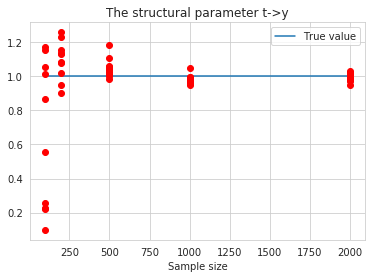

In [5]:
"""Plot results"""
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[c_yt])
plt.title("The structural parameter t->y")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, models[datasize][i].decoder.y_nn.weight[0,1].detach().numpy(),'ro',)

In [250]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=False)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9


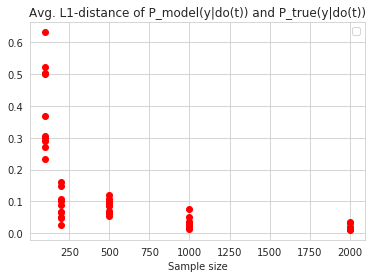

In [258]:
"""Plot results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 0, 'y')

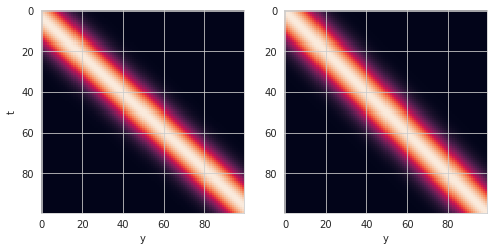

In [263]:
model = models[200][6]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=False)

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(py_dot_model)
axes[1].imshow(py_dot_true)
axes[0].set_xlabel("y")
axes[0].set_ylabel("t")
axes[1].set_xlabel("y")

## p(y|x,t) is a neural network
In this case we don't get a structural parameter from the model to compare to the value from the data generating process. $P(y|do(t)) = \int P(y|z,t)P(z) dz$ is the causal effect. Would $\int\int|\int P(y|z,t)P(z)dz - P_{true}(y|do(t))|dyP(t)dt = \int |P(y|do(t),P_{true}(y|do(t))|_{L_1} P(t) dt$ be an interesting thing to look at? 

$\frac{d}{dy}E(y|do(t))$ is the structural parameter. Maybe we could also see the average deviation of this thing from the true parameter, but maybe doesn't make much sense.

In [2]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [3]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 250#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_data_py_zt_nn"
name = "linear_py_zt_nn"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = True
q_z_xty_nn = False
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [ ]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_data_py_zt_nn/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[-0.3830, -0.6981]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[ 0.6919, -0.1460]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[0.2119, 0.6272]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[0.3250, 0.3002]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[ 0.2513, -0.4654]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.0195, -0.4556]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Par

In [12]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=1, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

In [62]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=200)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


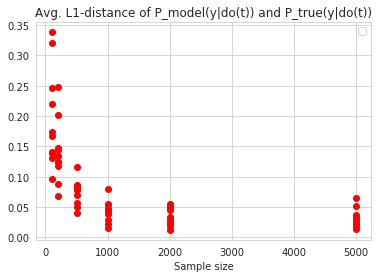

In [63]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'True P(y|do(t))')

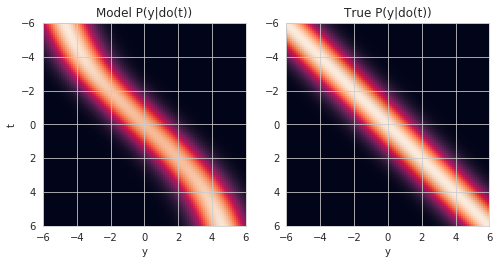

In [74]:
model = models[1000][1]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=True)

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[0].set_xlabel("y")
axes[0].set_ylabel("t")
axes[1].set_xlabel("y")
axes[0].set_title("Model P(y|do(t))")
axes[1].set_title("True P(y|do(t))")

## z_dim = 2

In [168]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [169]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 250#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 2
folder = "linear_data_zdim_2"
name = "linear_zdim_2"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = False
q_z_xty_nn = False
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [82]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[0.0400, 0.0612, 1.2128]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[-0.0154,  0.0585,  0.5498]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[-0.0073,  0.0523,  0.8008]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[-0.0124,  0.0548,  1.2958]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.0597, -0.0154,  0.5347]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.0064,  0.0344,  1.1459]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[-0.0138,  0

Estimated causal effect: Parameter containing:
tensor([[-0.6172,  0.0530,  0.9857]], requires_grad=True) true value: [1]
Training data size 5000, run 7
Estimated causal effect: Parameter containing:
tensor([[0.6202, 0.1844, 0.9710]], requires_grad=True) true value: [1]
Training data size 5000, run 8
Estimated causal effect: Parameter containing:
tensor([[-0.5987, -0.1224,  1.0095]], requires_grad=True) true value: [1]
Training data size 5000, run 9
Estimated causal effect: Parameter containing:
tensor([[0.0422, 0.5879, 1.0009]], requires_grad=True) true value: [1]
Training data size 5000, run 10
Estimated causal effect: Parameter containing:
tensor([[0.2057, 0.6178, 0.9809]], requires_grad=True) true value: [1]


In [170]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

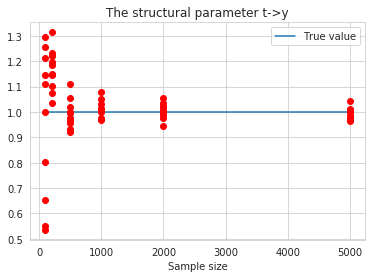

In [171]:
"""Plot results"""
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[c_yt])
plt.title("The structural parameter t->y")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, models[datasize][i].decoder.y_nn.weight[0,2].detach().numpy(),'ro',)

In [183]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist_general(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=50,z_dim=2)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


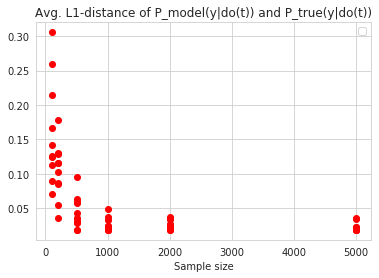

In [184]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'P(t)')

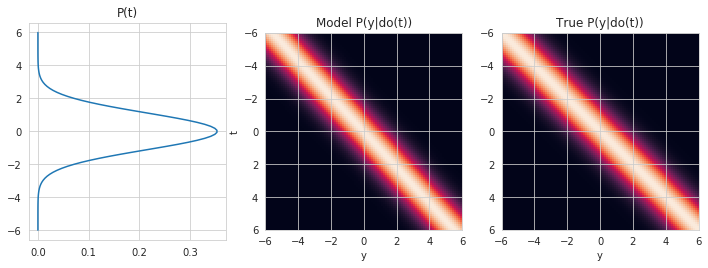

In [186]:
model = models[500][0]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist_general(model=model, n=100, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn, z_dim=z_dim)

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[1].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[2].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].set_xlabel("y")
axes[1].set_ylabel("t")
axes[2].set_xlabel("y")
axes[1].set_title("Model P(y|do(t))")
axes[2].set_title("True P(y|do(t))")
axes[0].plot(pt_true,t_range)
axes[0].set_title("P(t)")

## q(z|x,t,y) is a neural network TODO: these were overwritten

In [88]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [104]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 350#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_data_qz_xty_nn"
name = "linear_qz_xty_nn"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = False
q_z_xty_nn = True
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [105]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_data_qz_xty_nn/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[0.0096, 0.8432]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[-0.5959,  0.8565]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[0.2206, 1.2276]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[-0.5436,  1.1348]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.0025,  1.3060]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[0.5449, 0.7934]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Para

Estimated causal effect: Parameter containing:
tensor([[-0.5595,  1.0388]], requires_grad=True) true value: [1]
Training data size 5000, run 9
Estimated causal effect: Parameter containing:
tensor([[-0.5831,  1.0117]], requires_grad=True) true value: [1]
Training data size 5000, run 10
Estimated causal effect: Parameter containing:
tensor([[-0.5972,  0.9737]], requires_grad=True) true value: [1]


In [106]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

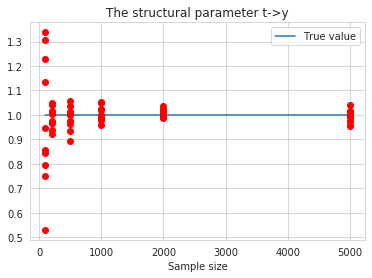

In [118]:
"""Plot results"""
#NOTE: why is 5000 worse than 2000? Problems with the optimization or real issues?
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[c_yt])
plt.title("The structural parameter t->y")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, models[datasize][i].decoder.y_nn.weight[0,1].detach().numpy(),'ro',)

In [109]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=200)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


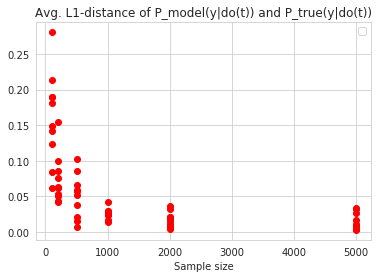

In [110]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'True P(y|do(t))')

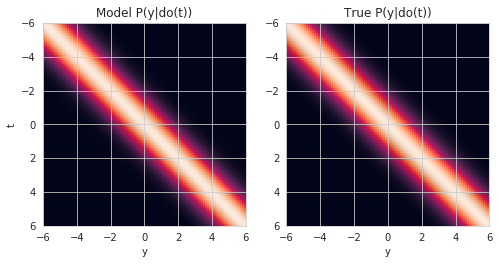

In [117]:
model = models[2000][3]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn)

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[0].set_xlabel("y")
axes[0].set_ylabel("t")
axes[1].set_xlabel("y")
axes[0].set_title("Model P(y|do(t))")
axes[1].set_title("True P(y|do(t))")

## p(y|z,t) and q(z|x,t,y) are neural networks

In [119]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [126]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 350#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_data_qz_xty_nn_py_zt_nn"
name = "linear_qz_xty_nn_py_zt_nn"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = True
q_z_xty_nn = True
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [127]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[-0.1046,  0.5822]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[0.4781, 0.2289]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[0.2427, 0.2734]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[ 0.6057, -0.4464]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[ 0.3083, -0.5400]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[0.1048, 0.1171]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[ 0.3611, -0.0948]], requires_grad=True) true value: [1]
Training dat

Estimated causal effect: Parameter containing:
tensor([[ 0.0761, -0.1313]], requires_grad=True) true value: [1]
Training data size 5000, run 10
Estimated causal effect: Parameter containing:
tensor([[-0.0582, -0.3268]], requires_grad=True) true value: [1]


In [128]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

In [130]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=200)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


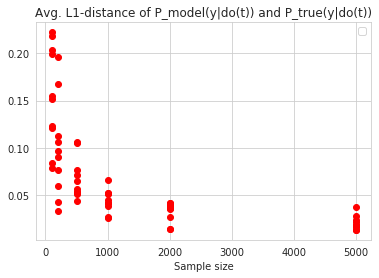

In [131]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'P(t)')

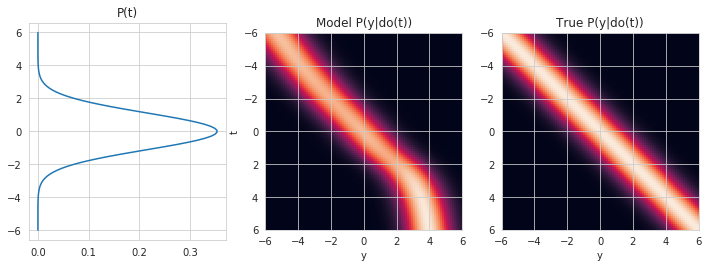

In [166]:
model = models[1000][0]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn)

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[1].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[2].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].set_xlabel("y")
axes[1].set_ylabel("t")
axes[2].set_xlabel("y")
axes[1].set_title("Model P(y|do(t))")
axes[2].set_title("True P(y|do(t))")
axes[0].plot(pt_true,t_range)
axes[0].set_title("P(t)")

## p(y|z,t) and q(z|x,t,y) are neural networks and zdim=2

In [187]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [188]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 350#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 2
folder = "linear_data_qz_xty_nn_py_zt_nn"
name = "linear_qz_xty_nn_py_zt_nn"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = True
q_z_xty_nn = True
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [189]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_data_qz_xty_nn_py_zt_nn/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[ 0.2646, -0.5047, -0.0572]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[-0.4288,  0.0900,  0.3555]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[ 0.5158, -0.4036,  0.4427]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[ 0.4285, -0.3440, -0.0537]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[0.4820, 0.1393, 0.4985]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.0366,  0.4598, -0.4960]], requires_grad=True) true valu

Estimated causal effect: Parameter containing:
tensor([[ 0.5763, -0.4375,  0.2060]], requires_grad=True) true value: [1]
Training data size 5000, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.1146,  0.4621,  0.5115]], requires_grad=True) true value: [1]
Training data size 5000, run 7
Estimated causal effect: Parameter containing:
tensor([[ 0.2658, -0.4400, -0.2644]], requires_grad=True) true value: [1]
Training data size 5000, run 8
Estimated causal effect: Parameter containing:
tensor([[-0.5526,  0.0481, -0.0307]], requires_grad=True) true value: [1]
Training data size 5000, run 9
Estimated causal effect: Parameter containing:
tensor([[-0.0500, -0.3863, -0.0925]], requires_grad=True) true value: [1]
Training data size 5000, run 10
Estimated causal effect: Parameter containing:
tensor([[0.2618, 0.0816, 0.4889]], requires_grad=True) true value: [1]


In [190]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist_general(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=50,z_dim=z_dim)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


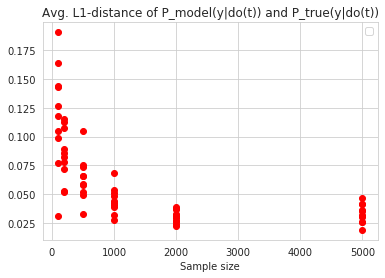

In [191]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'P(t)')

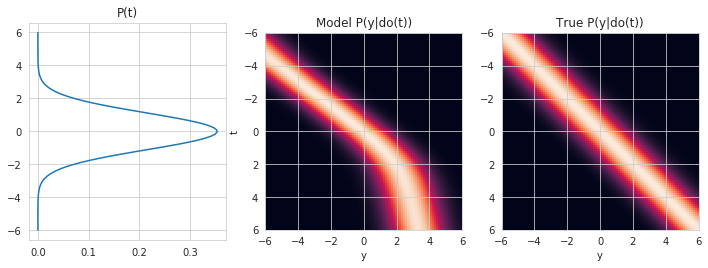

In [224]:
model = models[100][0]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist_general(model=model, n=100, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn, z_dim=z_dim)

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[1].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[2].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].set_xlabel("y")
axes[1].set_ylabel("t")
axes[2].set_xlabel("y")
axes[1].set_title("Model P(y|do(t))")
axes[2].set_title("True P(y|do(t))")
axes[0].plot(pt_true,t_range)
axes[0].set_title("P(t)")

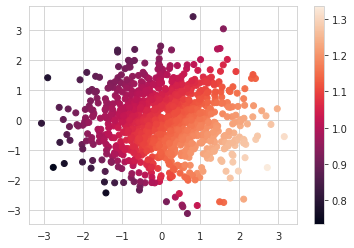

In [230]:
z = torch.cat([torch.randn((1000,2)),1*torch.ones((1000,1))], axis=1)
y_mean = model.decoder.y_nn_real(z)
plt.figure()
plt.scatter(z[:,0],z[:,1],c=y_mean.detach().numpy().squeeze())
plt.colorbar()

## Everything is a neural network, variances estimated for each unit separately

In [726]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [729]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 350#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 2
folder = "linear_data_everything_nn"
name = "linear_everything_nn"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = True
q_z_xty_nn = True
p_x_z_nn = True
p_t_z_nn = True
p_y_zt_std = True
p_x_z_std = True
p_t_z_std = True
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [ ]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device,
                        p_x_z_nn = p_x_z_nn, p_t_z_nn = p_t_z_nn, p_y_zt_std = p_y_zt_std, p_x_z_std = p_x_z_std,
                        p_t_z_std = p_t_z_std)

Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[-0.3146, -0.2924,  0.1352]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[-0.0056,  0.1811,  0.4727]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[-0.0288, -0.3126,  0.4487]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[0.1657, 0.2229, 0.0615]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[ 0.0152, -0.1670, -0.3578]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[0.4910, 0.2682, 0.0425]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[ 0.4877,  0.37

In [190]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist_general(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=50,z_dim=z_dim)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


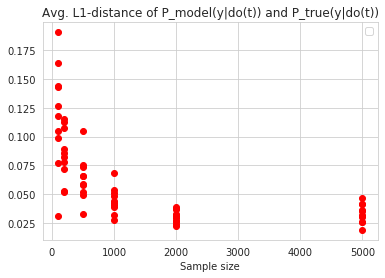

In [191]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'P(t)')

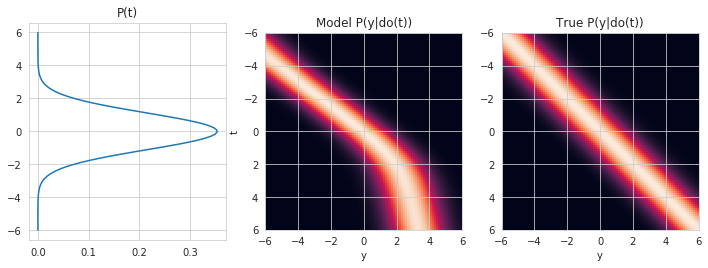

In [224]:
model = models[100][0]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist_general(model=model, n=100, c_yt=c_yt, c_yz=c_yz, s_y=s_y, c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn, z_dim=z_dim)

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[1].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[2].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].set_xlabel("y")
axes[1].set_ylabel("t")
axes[2].set_xlabel("y")
axes[1].set_title("Model P(y|do(t))")
axes[2].set_title("True P(y|do(t))")
axes[0].plot(pt_true,t_range)
axes[0].set_title("P(t)")

## Nonidentifiable model with only one proxy x

In [231]:
"""Let's define the model here"""
c_x = np.array([2])
s_x = np.array([0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [233]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 350#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 1
z_dim = 1
folder = "linear_data_1_proxy_x"
name = "linear_1_proxy_x"
BATCH_SIZE = 100
binary_t_y = False
p_y_zt_nn = False
q_z_xty_nn = False
dataparameters = [c_x, c_t, c_yz, c_yt, s_x, s_t, s_y]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y_nn.weight
true_value = c_yt
device = "cpu"

In [235]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        linear_data_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_data_1_proxy_x/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[0.0630, 1.1623]], requires_grad=True) true value: [1]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[0.0686, 1.0443]], requires_grad=True) true value: [1]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[0.0419, 1.1811]], requires_grad=True) true value: [1]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[-0.0262,  1.3251]], requires_grad=True) true value: [1]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.0178,  1.1701]], requires_grad=True) true value: [1]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[0.0484, 1.3454]], requires_grad=True) true value: [1]
Training data size 100, run 7
Estimated causal effect: Parame

Estimated causal effect: Parameter containing:
tensor([[0.8001, 0.8727]], requires_grad=True) true value: [1]
Training data size 5000, run 10
Estimated causal effect: Parameter containing:
tensor([[-0.8006,  0.8442]], requires_grad=True) true value: [1]


In [236]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

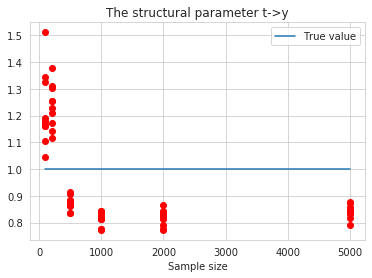

In [237]:
"""Plot results"""
#NOTE: why is 5000 worse than 2000? Problems with the optimization or real issues?
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[c_yt])
plt.title("The structural parameter t->y")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, models[datasize][i].decoder.y_nn.weight[0,1].detach().numpy(),'ro',)

In [239]:
avg_causal_dists = {}
for datasize in datasizes:
    avg_causal_dists[datasize] = {}
    for i in range(datasize_times):
        print("{},{}".format(datasize,i))
        model = models[datasize][i]
        avg_causal_dists[datasize][i],_,_,_,_,_ = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=200)

100,0
100,1
100,2
100,3
100,4
100,5
100,6
100,7
100,8
100,9
200,0
200,1
200,2
200,3
200,4
200,5
200,6
200,7
200,8
200,9
500,0
500,1
500,2
500,3
500,4
500,5
500,6
500,7
500,8
500,9
1000,0
1000,1
1000,2
1000,3
1000,4
1000,5
1000,6
1000,7
1000,8
1000,9
2000,0
2000,1
2000,2
2000,3
2000,4
2000,5
2000,6
2000,7
2000,8
2000,9
5000,0
5000,1
5000,2
5000,3
5000,4
5000,5
5000,6
5000,7
5000,8
5000,9


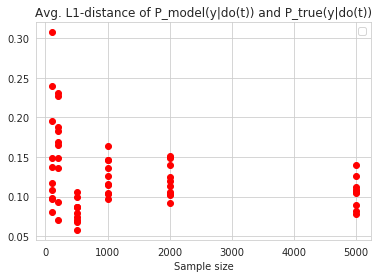

In [240]:
"""Plot causal distance results"""
plt.figure()
plt.xlabel("Sample size")
plt.legend(["True value"])
plt.title("Avg. L1-distance of P_model(y|do(t)) and P_true(y|do(t))")
for datasize in datasizes:
    for i in range(datasize_times):
        plt.plot(datasize, avg_causal_dists[datasize][i],'ro',)

Text(0.5, 1.0, 'P(t)')

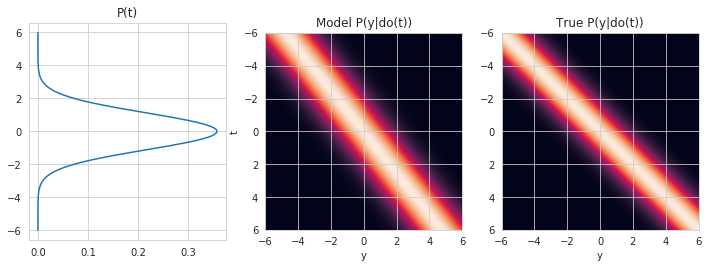

In [241]:
model = models[5000][0]
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=p_y_zt_nn,
                                                                  n=200)
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[1].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[2].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].set_xlabel("y")
axes[1].set_ylabel("t")
axes[2].set_xlabel("y")
axes[1].set_title("Model P(y|do(t))")
axes[2].set_title("True P(y|do(t))")
axes[0].plot(pt_true,t_range)
axes[0].set_title("P(t)")

# Testing on data with t, y binary

## Case with moderate nonlinearities

In [443]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
t_a = np.array([1])#Make this larger to amplify amplify nonlinearities
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])

In [444]:
p_y_zt1_true, p_y_zt0_true = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
true_ate = linear_binary_ty_ate(p_y_zt1_true, p_y_zt0_true)
print("True ATE: {}".format(true_ate))

True ATE: 0.15048506347526708


In [445]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 200#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_binary_data"
name = "linear_binary"
BATCH_SIZE = 100
binary_t_y = True
p_y_zt_nn = False
q_z_xty_nn = False
dataparameters = [c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y1_nn.weight
true_value = y_a1
device = "cpu"
generate_df = linear_data_binary_ty_df

In [450]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        generate_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_binary_data/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[0.0836]], requires_grad=True) true value: [2]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[0.0573]], requires_grad=True) true value: [2]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[-0.0418]], requires_grad=True) true value: [2]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[0.0561]], requires_grad=True) true value: [2]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.1671]], requires_grad=True) true value: [2]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.0387]], requires_grad=True) true value: [2]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[-0.1616]], requires_grad=Tr

In [451]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

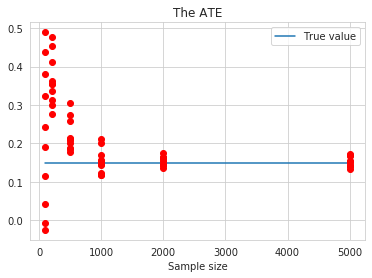

In [452]:
"""Plot results"""
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[true_ate])
plt.title("The ATE")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        p_y_zt1_model, p_y_zt0_model = p_y_zt_from_model(models[datasize][i], p_y_zt_nn)
        model_ate = linear_binary_ty_ate(p_y_zt1_model, p_y_zt0_model)
        plt.plot(datasize, model_ate,'ro',)

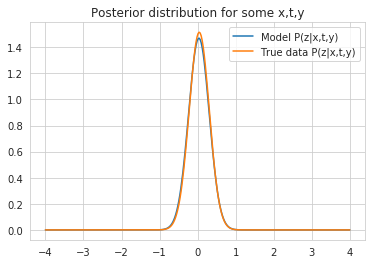

In [457]:
#Visualizing the inferred posterior distribution
model = models[5000][1]
x0 = 0
x1 = 0
mean = model.encoder.q_z_nn_t0y1(torch.Tensor([x0,x1])).detach().numpy()
std = torch.exp(model.encoder.z_logstd_t0y1).detach().numpy()

lim = 4
n = 300
z = np.linspace(-lim,lim,n)
def sigmoid(x):
    return 1/(1+np.exp(-x))
pz_xty = scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *(1-sigmoid(t_a*z + t_b))*sigmoid(y_a0*z + y_b0) \
        *scipy.stats.norm.pdf(z)
pz_xty = pz_xty / (pz_xty.sum()*2*lim/n)

plt.figure()
plt.plot(z, scipy.stats.norm.pdf(z,loc=mean, scale=std))
num_samples = 100000
df = linear_data_binary_ty_df(num_samples, c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1)
plt.plot(z,pz_xty)
plt.legend(['Model P(z|x,t,y)', 'True data P(z|x,t,y)'])
plt.title("Posterior distribution for some x,t,y")
plt.show()

## Case with strong nonlinearities

In [540]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
t_a = np.array([10])#Make this larger to amplify amplify nonlinearities
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])

In [541]:
p_y_zt1_true, p_y_zt0_true = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
true_ate = linear_binary_ty_ate(p_y_zt1_true, p_y_zt0_true)
print("True ATE: {}".format(true_ate))

True ATE: 0.15048506347526708


In [542]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 200#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_binary_data_strong_nonlinear"
name = "linear_binary_strong_nonlinear"
BATCH_SIZE = 100
binary_t_y = True
p_y_zt_nn = False
q_z_xty_nn = False
dataparameters = [c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y1_nn.weight
true_value = y_a1
device = "cpu"
generate_df = linear_data_binary_ty_df

In [543]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        generate_df, dataparameters, track_function, true_value, device)

Creation of the directory data/linear_binary_data_strong_nonlinear/ failed. Trying to empty the same folder.
Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[-0.2862]], requires_grad=True) true value: [2]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[0.0143]], requires_grad=True) true value: [2]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[-0.0550]], requires_grad=True) true value: [2]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[-0.0668]], requires_grad=True) true value: [2]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.1740]], requires_grad=True) true value: [2]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.2252]], requires_grad=True) true value: [2]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[-0.2228]

In [547]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

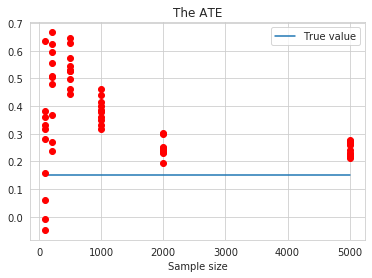

In [548]:
"""Plot results"""
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[true_ate])
plt.title("The ATE")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        p_y_zt1_model, p_y_zt0_model = p_y_zt_from_model(models[datasize][i], p_y_zt_nn)
        model_ate = linear_binary_ty_ate(p_y_zt1_model, p_y_zt0_model)
        plt.plot(datasize, model_ate,'ro',)

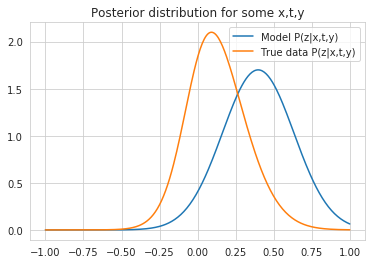

In [564]:
#Visualizing the inferred posterior distribution
model = models[5000][1]
x0 = 1
x1 = 1
mean = model.encoder.q_z_nn_t0y1(torch.Tensor([x0,x1])).detach().numpy()
std = torch.exp(model.encoder.z_logstd_t0y1).detach().numpy()

lim = 1
n = 300
z = np.linspace(-lim,lim,n)
def sigmoid(x):
    return 1/(1+np.exp(-x))
pz_xty = scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *(1-sigmoid(t_a*z + t_b))*sigmoid(y_a0*z + y_b0) \
        *scipy.stats.norm.pdf(z)
pz_xty = pz_xty / (pz_xty.sum()*2*lim/n)

plt.figure()
plt.plot(z, scipy.stats.norm.pdf(z,loc=mean, scale=std))
#num_samples = 100000
#df = linear_data_binary_ty_df(num_samples, c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1)
plt.plot(z,pz_xty)
plt.legend(['Model P(z|x,t,y)', 'True data P(z|x,t,y)'])
plt.title("Posterior distribution for some x,t,y")
plt.show()

## Strong nonlinearities, q(z|x,t,y) is a neural network and its variance is estimated for each sample

In [589]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
t_a = np.array([10])#Make this larger to amplify amplify nonlinearities
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])

In [590]:
p_y_zt1_true, p_y_zt0_true = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
true_ate = linear_binary_ty_ate(p_y_zt1_true, p_y_zt0_true)
print("True ATE: {}".format(true_ate))

True ATE: 0.15048506347526708


In [591]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 200#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_binary_data_strong_nonlinear_nn"
name = "linear_binary_strong_nonlinear_nn"
BATCH_SIZE = 100
binary_t_y = True
p_y_zt_nn = False
q_z_xty_nn = True
dataparameters = [c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y1_nn.weight
true_value = y_a1
device = "cpu"
generate_df = linear_data_binary_ty_df

In [592]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        generate_df, dataparameters, track_function, true_value, device)

Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[-1.0327]], requires_grad=True) true value: [2]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[1.2918]], requires_grad=True) true value: [2]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[1.0182]], requires_grad=True) true value: [2]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[-0.0720]], requires_grad=True) true value: [2]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.4055]], requires_grad=True) true value: [2]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[-0.1219]], requires_grad=True) true value: [2]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[0.2297]], requires_grad=True) true value: [2]
Training data size 100, run 8
Estimated causal effect: Parameter contain

In [593]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

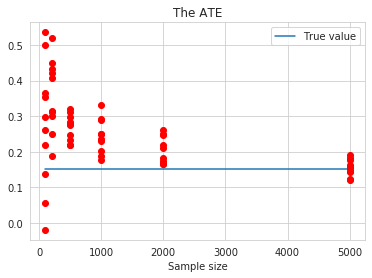

In [594]:
"""Plot results"""
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[true_ate])
plt.title("The ATE")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        p_y_zt1_model, p_y_zt0_model = p_y_zt_from_model(models[datasize][i], p_y_zt_nn)
        model_ate = linear_binary_ty_ate(p_y_zt1_model, p_y_zt0_model)
        plt.plot(datasize, model_ate,'ro',)

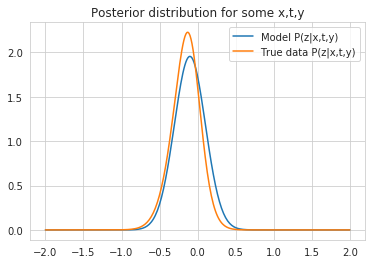

In [604]:
#Visualizing the inferred posterior distribution
model = models[5000][2]
x0 = 0
x1 = 0
mean = model.encoder.q_z_nn_t0y1_real(torch.Tensor([x0,x1]))[0].detach().numpy()
std = torch.exp(model.encoder.q_z_nn_t0y1_real(torch.Tensor([x0,x1]))[1]).detach().numpy()

lim = 2
n = 300
z = np.linspace(-lim,lim,n)
def sigmoid(x):
    return 1/(1+np.exp(-x))
pz_xty = scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *(1-sigmoid(t_a*z + t_b))*sigmoid(y_a0*z + y_b0) \
        *scipy.stats.norm.pdf(z)
pz_xty = pz_xty / (pz_xty.sum()*2*lim/n)

plt.figure()
plt.plot(z, scipy.stats.norm.pdf(z,loc=mean, scale=std))
#num_samples = 100000
#df = linear_data_binary_ty_df(num_samples, c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1)
plt.plot(z,pz_xty)
plt.legend(['Model P(z|x,t,y)', 'True data P(z|x,t,y)'])
plt.title("Posterior distribution for some x,t,y")
plt.show()

## More strong nonlinearities, q(z|x,t,y) is a neural network and its variance is estimated for each sample

In [629]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
t_a = np.array([50])#Make this larger to amplify amplify nonlinearities
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])

In [630]:
p_y_zt1_true, p_y_zt0_true = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
true_ate = linear_binary_ty_ate(p_y_zt1_true, p_y_zt0_true)
print("True ATE: {}".format(true_ate))

True ATE: 0.15048506347526708


In [632]:
"""define all kinds of other things"""
datasizes = [100,200,500,1000,2000,5000]
datasize_times = 10
num_epochs = 200#Should be about enough to train the 100 case with these parameters as well
lr_start = 0.01
lr_end = 0.001
input_dim = 2
z_dim = 1
folder = "linear_binary_data_stronger_nonlinear_nn"
name = "linear_binary_stronger_nonlinear_nn"
BATCH_SIZE = 100
binary_t_y = True
p_y_zt_nn = False
q_z_xty_nn = True
dataparameters = [c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1]#Be careful that these are the correct way around
track_function = lambda model: model.decoder.y1_nn.weight
true_value = y_a1
device = "cpu"
generate_df = linear_data_binary_ty_df

In [633]:
"""Run the training of the model. Skip this cell if you just want to reload the data."""
dfs, models = run_model_for_data_sets(datasizes,datasize_times,num_epochs,lr_start,lr_end,input_dim,z_dim,
                       folder,name,BATCH_SIZE,binary_t_y,p_y_zt_nn,q_z_xty_nn,
                        generate_df, dataparameters, track_function, true_value, device)

Training data size 100, run 1
Estimated causal effect: Parameter containing:
tensor([[0.2164]], requires_grad=True) true value: [2]
Training data size 100, run 2
Estimated causal effect: Parameter containing:
tensor([[0.2684]], requires_grad=True) true value: [2]
Training data size 100, run 3
Estimated causal effect: Parameter containing:
tensor([[0.3863]], requires_grad=True) true value: [2]
Training data size 100, run 4
Estimated causal effect: Parameter containing:
tensor([[-0.9859]], requires_grad=True) true value: [2]
Training data size 100, run 5
Estimated causal effect: Parameter containing:
tensor([[-0.9726]], requires_grad=True) true value: [2]
Training data size 100, run 6
Estimated causal effect: Parameter containing:
tensor([[0.7551]], requires_grad=True) true value: [2]
Training data size 100, run 7
Estimated causal effect: Parameter containing:
tensor([[0.2993]], requires_grad=True) true value: [2]
Training data size 100, run 8
Estimated causal effect: Parameter containin

In [634]:
"""Load the generated data"""
dfs, models = load_dfs_models(folder, name, datasizes, datasize_times,
                   input_dim=input_dim, z_dim=z_dim, device=device, binary_t_y=binary_t_y,
                  p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=q_z_xty_nn)
datasizes = sorted(list(models.keys()))
datasize_times = max(list(models[next(iter(models))].keys()))+1

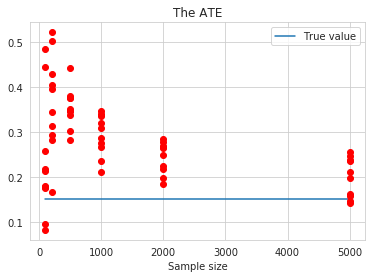

In [635]:
"""Plot results"""
plt.figure()
plt.plot([datasizes[0], datasizes[-1]], 2*[true_ate])
plt.title("The ATE")
plt.xlabel("Sample size")
plt.legend(["True value"])
for datasize in datasizes:
    for i in range(datasize_times):
        p_y_zt1_model, p_y_zt0_model = p_y_zt_from_model(models[datasize][i], p_y_zt_nn)
        model_ate = linear_binary_ty_ate(p_y_zt1_model, p_y_zt0_model)
        plt.plot(datasize, model_ate,'ro',)

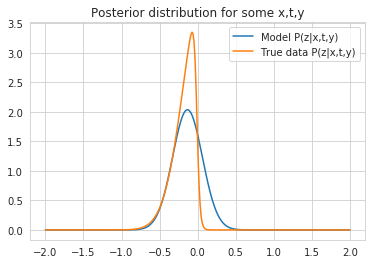

In [645]:
#Visualizing the inferred posterior distribution
model = models[5000][2]
x0 = 0
x1 = 0
mean = model.encoder.q_z_nn_t0y1_real(torch.Tensor([x0,x1]))[0].detach().numpy()
std = torch.exp(model.encoder.q_z_nn_t0y1_real(torch.Tensor([x0,x1]))[1]).detach().numpy()

lim = 2
n = 300
z = np.linspace(-lim,lim,n)
def sigmoid(x):
    return 1/(1+np.exp(-x))
pz_xty = scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *(1-sigmoid(t_a*z + t_b))*sigmoid(y_a0*z + y_b0) \
        *scipy.stats.norm.pdf(z)
pz_xty = pz_xty / (pz_xty.sum()*2*lim/n)

plt.figure()
plt.plot(z, scipy.stats.norm.pdf(z,loc=mean, scale=std))
#num_samples = 100000
#df = linear_data_binary_ty_df(num_samples, c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1)
plt.plot(z,pz_xty)
plt.legend(['Model P(z|x,t,y)', 'True data P(z|x,t,y)'])
plt.title("Posterior distribution for some x,t,y")
plt.show()

## Individual "perfect" linear model testing

In [647]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

In [720]:
%autoreload 2
BATCH_SIZE = 1000
num_samples = 10000
df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
dataset = LinearDataset(df)
dataloader = LinearDataLoader(dataset, validation_split=0.0)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
#dummy test loader
test_loader, _ = LinearDataLoader(LinearDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)

Training Results - Epoch 1 - y_reconc_loss: 1636.5916 x_reconc_loss: 3745.6389 t_reconc_loss: 1530.4107 kld_loss: 39.4921 total_loss: 6952.1333 learning rate: 0.0977
Training Results - Epoch 2 - y_reconc_loss: 1640.3316 x_reconc_loss: 3701.2331 t_reconc_loss: 1526.3103 kld_loss: 12.2267 total_loss: 6880.1017 learning rate: 0.0955
Training Results - Epoch 3 - y_reconc_loss: 1591.6896 x_reconc_loss: 3692.7550 t_reconc_loss: 1525.2132 kld_loss: 5.7154 total_loss: 6815.3731 learning rate: 0.0933
Training Results - Epoch 4 - y_reconc_loss: 1575.8052 x_reconc_loss: 3684.6847 t_reconc_loss: 1524.0898 kld_loss: 5.6523 total_loss: 6790.2321 learning rate: 0.0912
Training Results - Epoch 5 - y_reconc_loss: 1559.2797 x_reconc_loss: 3683.2863 t_reconc_loss: 1526.4098 kld_loss: 2.5510 total_loss: 6771.5269 learning rate: 0.0891
Training Results - Epoch 6 - y_reconc_loss: 1556.3734 x_reconc_loss: 3683.0006 t_reconc_loss: 1526.7022 kld_loss: 2.5738 total_loss: 6768.6500 learning rate: 0.0871
Training

Training Results - Epoch 50 - y_reconc_loss: 1415.1623 x_reconc_loss: 1865.3741 t_reconc_loss: 1415.9717 kld_loss: 1256.1049 total_loss: 5952.6128 learning rate: 0.0316
Training Results - Epoch 51 - y_reconc_loss: 1415.4755 x_reconc_loss: 1892.8524 t_reconc_loss: 1418.2519 kld_loss: 1226.1197 total_loss: 5952.6996 learning rate: 0.0309
Training Results - Epoch 52 - y_reconc_loss: 1420.6481 x_reconc_loss: 1880.0646 t_reconc_loss: 1418.4022 kld_loss: 1225.4174 total_loss: 5944.5322 learning rate: 0.0302
Training Results - Epoch 53 - y_reconc_loss: 1418.4889 x_reconc_loss: 1836.1150 t_reconc_loss: 1410.7198 kld_loss: 1276.2730 total_loss: 5941.5967 learning rate: 0.0295
Training Results - Epoch 54 - y_reconc_loss: 1415.6250 x_reconc_loss: 1831.7893 t_reconc_loss: 1414.5404 kld_loss: 1265.7431 total_loss: 5927.6978 learning rate: 0.0288
Training Results - Epoch 55 - y_reconc_loss: 1421.3772 x_reconc_loss: 1903.5696 t_reconc_loss: 1413.7396 kld_loss: 1194.8341 total_loss: 5933.5206 learning

Training Results - Epoch 99 - y_reconc_loss: 1415.4383 x_reconc_loss: 1821.2747 t_reconc_loss: 1415.3775 kld_loss: 1260.5304 total_loss: 5912.6209 learning rate: 0.0102
Training Results - Epoch 100 - y_reconc_loss: 1420.5650 x_reconc_loss: 1839.1419 t_reconc_loss: 1417.9250 kld_loss: 1261.6073 total_loss: 5939.2390 learning rate: 0.0100


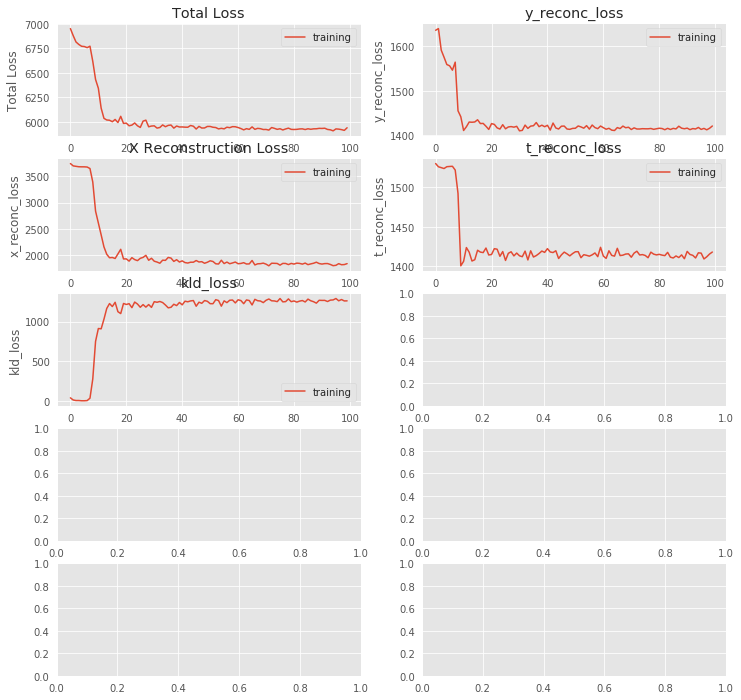

In [724]:
#Running the model
device = 'cpu'
model = run_cevae(num_epochs=100, lr_start=0.1, lr_end=0.01,
        train_loader=train_loader, test_loader=test_loader, input_dim=2,
        plot_curves=True, print_logs=True, device=device, z_dim=2, q_z_xty_nn=True, p_y_zt_nn=True,
        p_x_z_nn = True, p_t_z_nn = True, p_y_zt_std = True, p_x_z_std = True, p_t_z_std = True)

In [660]:
print(model.decoder.x_nns[0].weight)
print(model.decoder.x_nns[1].weight)
print(model.decoder.t_nn.weight)
print(model.decoder.y_nn.weight)
print(torch.exp(model.decoder.x_log_std))
print(torch.exp(model.decoder.t_log_std))
print(torch.exp(model.decoder.y_log_std))

Parameter containing:
tensor([[ 0.2615, -0.6190]], requires_grad=True)
Parameter containing:
tensor([[0.5203, 0.6750]], requires_grad=True)
Parameter containing:
tensor([[ 0.5386, -0.5823]], requires_grad=True)
Parameter containing:
tensor([[0.1480, 0.4352, 0.0488]], requires_grad=True)
tensor([0.4927, 0.7467], grad_fn=<ExpBackward>)
tensor([0.9903], grad_fn=<ExpBackward>)
tensor([0.9850], grad_fn=<ExpBackward>)


Text(0.5, 1.0, 'P(t)')

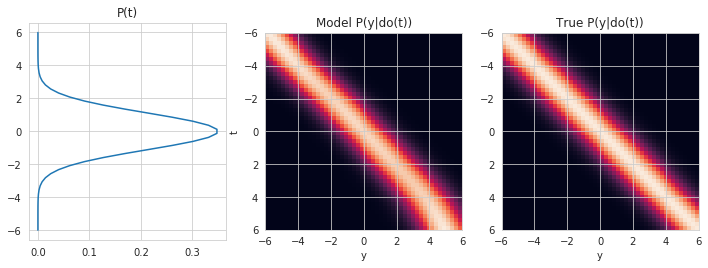

In [725]:
avg_causal_dist, py_dot_model, py_dot_true, y_range, t_range, pt_true = avg_causal_L1_dist_general(model=model, c_yt=c_yt, c_yz=c_yz, s_y=s_y, 
                                                                   c_t=c_t, s_t=s_t, c_x=c_x, p_y_zt_nn=True, z_dim=2,
                                                                  n=50)
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[1].imshow(py_dot_model, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[2].imshow(py_dot_true, extent=(y_range[0], y_range[-1], t_range[-1],t_range[0]))
axes[1].set_xlabel("y")
axes[1].set_ylabel("t")
axes[2].set_xlabel("y")
axes[1].set_title("Model P(y|do(t))")
axes[2].set_title("True P(y|do(t))")
axes[0].plot(pt_true,t_range)
axes[0].set_title("P(t)")

## Individual t,y binary model testing

In [622]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
t_a = np.array([50])#Make this larger to amplify amplify nonlinearities
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])

In [623]:
sigmoid(t_a*0+t_b)

array([0.62245933])

In [624]:
p_y_zt1_true, p_y_zt0_true = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
true_ate = linear_binary_ty_ate(p_y_zt1_true, p_y_zt0_true)
print("True ATE: {}".format(true_ate))

True ATE: 0.15048506347526708


In [625]:
BATCH_SIZE = 100
num_samples = 10000
df = linear_data_binary_ty_df(num_samples, c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_b1)
dataset = LinearDataset(df)
dataloader = LinearDataLoader(dataset, validation_split=0.0)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
#dummy test loader
test_loader, _ = LinearDataLoader(LinearDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)

Training Results - Epoch 1 - y_reconc_loss: 43.8624 x_reconc_loss: 321.2677 t_reconc_loss: 43.8298 kld_loss: 43.9242 total_loss: 452.8841 learning rate: 0.0095
Training Results - Epoch 2 - y_reconc_loss: 40.7915 x_reconc_loss: 207.0283 t_reconc_loss: 28.7718 kld_loss: 112.6315 total_loss: 389.2231 learning rate: 0.0091
Training Results - Epoch 3 - y_reconc_loss: 40.5159 x_reconc_loss: 186.8893 t_reconc_loss: 24.1578 kld_loss: 126.6809 total_loss: 378.2440 learning rate: 0.0087
Training Results - Epoch 4 - y_reconc_loss: 39.2122 x_reconc_loss: 182.9458 t_reconc_loss: 24.0874 kld_loss: 130.8956 total_loss: 377.1410 learning rate: 0.0083
Training Results - Epoch 5 - y_reconc_loss: 38.7406 x_reconc_loss: 180.7580 t_reconc_loss: 20.0822 kld_loss: 137.7549 total_loss: 377.3357 learning rate: 0.0079
Training Results - Epoch 6 - y_reconc_loss: 39.9992 x_reconc_loss: 179.3196 t_reconc_loss: 23.4460 kld_loss: 130.2453 total_loss: 373.0100 learning rate: 0.0076
Training Results - Epoch 7 - y_reco

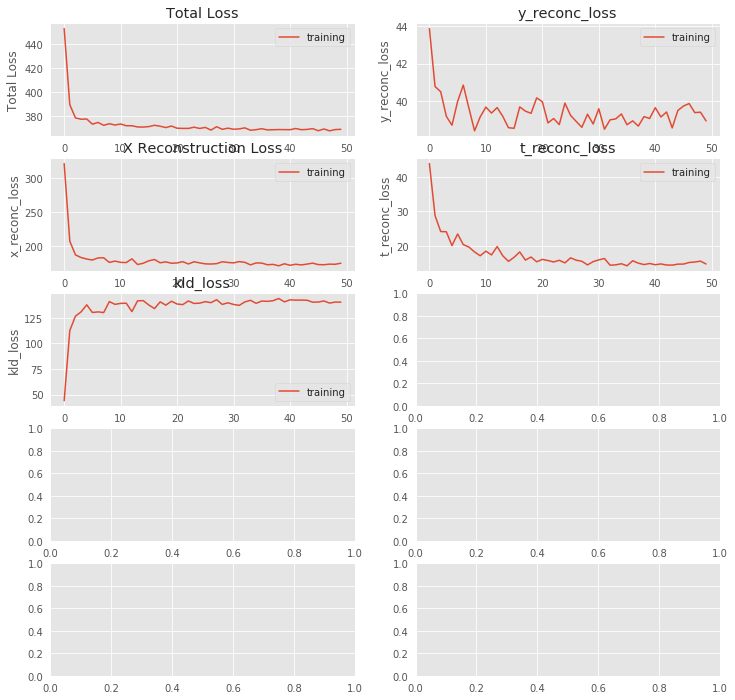

In [626]:
#Running the model
device = 'cpu'
p_y_zt_nn = False
model = run_cevae(num_epochs=50, lr_start=0.01, lr_end=0.001,
        train_loader=train_loader, test_loader=test_loader, input_dim=2,
        plot_curves=True, print_logs=True, device=device,
        binary_t_y=True, p_y_zt_nn=p_y_zt_nn, q_z_xty_nn=True)

In [627]:
print("x0 ", model.decoder.x_nns[0].weight)
print("x1 ",model.decoder.x_nns[1].weight)
print("t ",model.decoder.treatment_pred.weight, model.decoder.treatment_pred.bias)
print("y ",model.decoder.y0_nn.weight, model.decoder.y0_nn.bias,
      model.decoder.y1_nn.weight, model.decoder.y1_nn.bias)
print("x stds: ", torch.exp(model.decoder.x_log_std))
p_y_zt1_model, p_y_zt0_model = p_y_zt_from_model(model, p_y_zt_nn)
model_ate = linear_binary_ty_ate(p_y_zt1_model, p_y_zt0_model)
print("Model ATE: {}".format(model_ate))
linear_binary_ty_ate_2(p_y_zt1_model, p_y_zt0_model)

x0  Parameter containing:
tensor([[-0.9941]], requires_grad=True)
x1  Parameter containing:
tensor([[-1.9898]], requires_grad=True)
t  Parameter containing:
tensor([[-7.5166]], requires_grad=True) Parameter containing:
tensor([0.1836], requires_grad=True)
y  Parameter containing:
tensor([[-1.6250]], requires_grad=True) Parameter containing:
tensor([-0.7144], requires_grad=True) Parameter containing:
tensor([[-1.6894]], requires_grad=True) Parameter containing:
tensor([0.6142], requires_grad=True)
x stds:  tensor([0.4964, 0.6621], grad_fn=<ExpBackward>)
Model ATE: 0.22055167493800826


0.22055167444449486

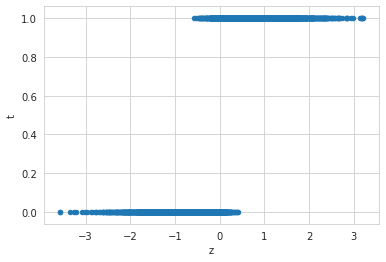

In [574]:
df.plot('z','t',kind='scatter')

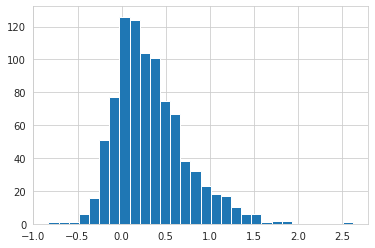

In [612]:
#P(z|t,y) visualization
df[(df.t == 1) & (df.y == 0)].z.hist(bins=30)

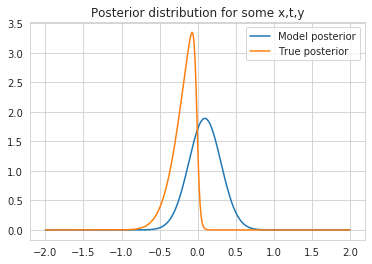

In [628]:
lim = 2
n = 300
z = np.linspace(-lim,lim,n)
x0=0
x1=0
mean = model.encoder.q_z_nn_t0y1_real(torch.Tensor([x0,x1]))[0].detach().numpy()
std = torch.exp(model.encoder.q_z_nn_t0y1_real(torch.Tensor([x0,x1]))[1]).detach().numpy()

def sigmoid(x):
    return 1/(1+np.exp(-x))
pz_xty = scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *(1-sigmoid(t_a*z + t_b))*sigmoid(y_a0*z + y_b0) \
        *scipy.stats.norm.pdf(z)
pz_xty = pz_xty / (pz_xty.sum()*2*lim/n)

plt.figure()
plt.plot(z, scipy.stats.norm.pdf(z,loc=mean, scale=std))
plt.plot(z,pz_xty)
plt.legend(["Model posterior", "True posterior"])
plt.title("Posterior distribution for some x,t,y")
plt.show()

## Something else

In [348]:
z_mean, z_std, x_pred, t_pred, y_pred = model(X,t,y)

In [72]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
t_a = np.array([10])
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])
num_samples = 1000000
df = linear_data_binary_ty_df(num_samples, c_x, s_x, t_a, t_b, y_a0, y_b0, y_a1, y_a0)

In [73]:
df

,z,x0,x1,t,y
0,0.915644,0.681552,1.115533,0.0,0.0
1,-1.712460,-2.677524,-4.370073,1.0,1.0
2,0.324937,0.509831,0.922870,0.0,0.0
3,1.101790,1.471415,0.389420,0.0,0.0
4,-0.988131,-1.290054,-0.713494,1.0,0.0
...,...,...,...,...,...
999995,0.530777,0.858386,0.643570,0.0,1.0
999996,0.895086,1.307019,0.914915,0.0,0.0
999997,-0.204620,-0.159130,-0.658198,1.0,1.0
999998,-0.218150,-0.480502,-1.084108,1.0,0.0


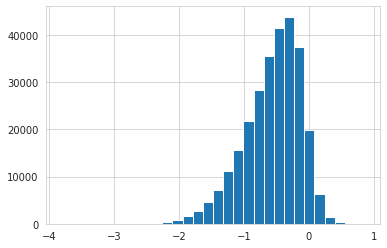

In [78]:
df[(df.t == 1) & (df.y == 0)].z.hist(bins=30)